In [1]:
import zipfile
import cv2
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    num_classes = len(np.unique(train_labels))  # 类别数量
    num_samples_per_class = train_data.shape[0] // num_classes  # 每个类别的样本数
    num_features = train_data.shape[1]  # 每个样本的特征维度
    
    means = np.zeros((num_classes, num_features))  # 存储每个类别的均值矩阵
    
    for i in range(1, num_classes + 1):  # 遍历每个类别
        temp_indices = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.sum(train_data[temp_indices], axis=0)  # 计算当前类别的特征值总和
        means[i-1] = temp_sum / num_samples_per_class  # 计算当前类别的均值
        
    return means  # 返回每个类别的均值矩阵

# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值
    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）

# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引
        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵
        
    return Z  # 返回中心类别矩阵

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    Sw = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return Sw  # 返回类内散布矩阵

In [3]:
def ShowEigenface(eigenfaces,faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    print("显示特征脸")
    plt.show()

In [4]:
def read_images(dataset_dir, target_size=(32, 32)):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 缩放图像至目标尺寸
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    train_samples = int(num_samples * train_test_split_ratio)  # 训练集样本数

    # 随机打乱数据集
    indices = np.random.permutation(num_samples)
    data = data[indices]
    labels = labels[indices]
    
    # 划分训练集和测试集
    train_data = data[:train_samples]
    train_labels = labels[:train_samples]
    test_data = data[train_samples:]
    test_labels = labels[train_samples:]
    
    return train_data, train_labels, test_data, test_labels


In [5]:
def MLDA(train_data, train_labels, faceshape, d):
    """
    使用多元线性判别分析（MLDA）进行特征提取。

    Args:
    - train_data: 训练数据集的特征矩阵
    - train_labels: 训练数据集的标签
    - d: 要提取的特征数量

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    - selected_eigenvalues: 特征值
    """
    # 计算每个类别的均值矩阵
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    print('classes_means形状：', classes_means.shape)

    # 计算所有类别的整体均值矩阵
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('overall_mean形状：', overall_mean.shape)

    # 计算中心类别矩阵
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)
    print('Z形状：', Z.shape)

    # 计算类间散布矩阵
    Sb = compute_between_class_scatter_matrix(classes_means, overall_mean)
    print('Sb形状：', Sb.shape)

    # 计算类内散布矩阵
    Sw = compute_class_scatter_matrix(Z)
    print('Sw形状：', Sw.shape)

    W_value = np.dot(np.linalg.inv(Sw), Sb)  # 计算投影矩阵W
    print(W_value.shape)  # 输出投影矩阵W的形状

    # 计算广义特征值问题的特征值和特征向量，提取前d个最大特征值对应的特征向量
    eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((faceshape[0] * faceshape[1]-d),(faceshape[0] * faceshape[1]-1)))  # 计算特征值和特征向量
    print('Done LDA selected eigenvectors computing')  # 输出提示信息
    print('LDA特征脸形状：', eigen_vectors.shape)
    ShowEigenface(eigen_vectors, faceshape)
    return eigen_vectors, overall_mean

labels shape:  (400, 1)
train_labels shape:  (200, 1)
test_labels shape:  (200, 1)
classes_means形状： (40, 1024)
overall_mean形状： (1024, 1)
Z形状： (200, 1024)


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_12384\2386802214.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引


Sb形状： (1024, 1024)
Sw形状： (1024, 1024)
(1024, 1024)


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_12384\2355870341.py:38: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((faceshape[0] * faceshape[1]-d),(faceshape[0] * faceshape[1]-1)))  # 计算特征值和特征向量


Done LDA selected eigenvectors computing
LDA特征脸形状： (1024, 40)
显示特征脸


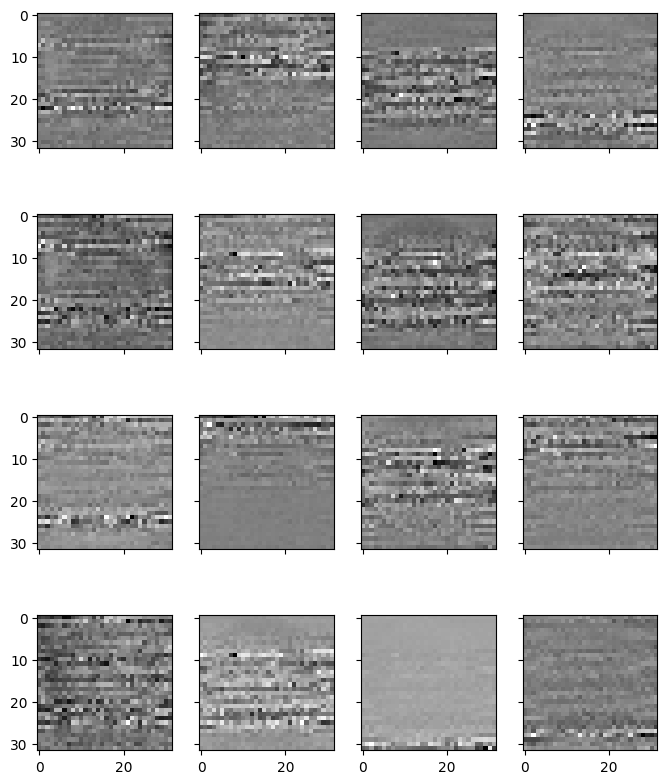

In [6]:
data, labels, faceshape = read_images("attfaces")  # 读取图像数据和标签
print("labels shape: ", labels.shape)  # 输出标签的形状

train_data, train_labels, test_data, test_labels = train_test_split(data, labels, 0.5)  # 划分训练集和测试集
print("train_labels shape: ", train_labels.shape)  # 输出训练集标签的形状
print("test_labels shape: ", test_labels.shape)  # 输出测试集标签的形状

d=40
eigen_vectors, overall_mean = MLDA(train_data, train_labels, faceshape, d)


In [7]:
# 测试要查询的图像
def test_query_class_sample(W, query_image, j, overall_mean, train_data):
    # 计算查询图像的线性判别函数值,即计算 d(Q) = W^T (Q - P)
    d = np.dot(W.T, (query_image - overall_mean))
    # 计算 ||d||
    discriminant_values = []
    for i in range(train_data.shape[0]):
        train_image = train_data[i]
        train_d = np.dot(W.T, (train_image - overall_mean))
        discriminant_value = np.linalg.norm(d - train_d)
        discriminant_values.append(discriminant_value)
    # 找到匹配的样本图像索引
    best_match_index = np.argmin(discriminant_values)
    
    #判断是否匹配正确
    flag = True
    if train_labels[best_match_index] == test_labels[j]:
        flag = True
    else:
        flag = False
    '''
    # 可视化测试图像和最佳匹配图像
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(query_image.reshape(faceshape), cmap='gray')
    axes[0].set_title('Query Image')
    axes[0].axis('off')
    axes[1].imshow(train_data[best_match_index].reshape(faceshape), cmap='gray')
    axes[1].set_title(f'Best Match Image (||d|| = {discriminant_values[best_match_index]:.2f})')
    axes[1].axis('off')
    plt.show()
    '''
    # 返回匹配结果
    return flag


In [8]:
# 测试已存在类别的样本图像
#for i in range(20):
    #test_query_class_sample(eigen_vectors, test_data[i], overall_mean, train_data)

In [9]:
# 识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_query_class_sample(eigen_vectors, test_data[i], i, overall_mean, train_data)
    if flag:
                right_times += 1         
    else:
        wrong_times += 1
rate = right_times / (right_times + wrong_times)
print(f"Recognition Rate: {rate}")


Recognition Rate: 0.91
